In [27]:
import ipywidgets as widgets  #Loads logo
file = open("images/Logo_for_app_3.png", "rb")
image = file.read()
logo=widgets.Image(
    value=image,
    format='png',
    width=300,
    height=400,
)
logo

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x12\xbe\x00\x00\x03\xfa\x08\x02\x00\x00\x00W\xad\r\'…

# Tight-Binding Electronic Transport Application for graphene nanoribbon junctions

Select the parameters defining the structure of your GNR junction. Some options are only active for specific junction angle or lead width. Additional information on the parameters is displayed *when the cursor is placed over the parameter name*. Atoms can be removed from the initial junction structure by entering their numbers separated by a comma (,) and pressing '*Remove atoms*'. Button '*Reset system*' returns the junction structure to its initial state. Band structure of the selected GNR leads is displayed next to the junction structure. At present, the application allows defining only the junctions with identical armchair GNR leads.

In [109]:
import kwant
from math import *
import matplotlib.pyplot as plt
import numpy as np
import operator
import matplotlib
from matplotlib import cm
from cmath import phase
import matplotlib as mpl
import cmocean
import unicodedata
from matplotlib import gridspec
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Label
import ipywidgets as widgets
import pyperclip


MEDIUM_SIZE = 16
BIGGER_SIZE = 16


plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

#Builds the system, need to specify angle A and width W, for even W, specify chirality F=0(default) or 1.
#For 120 degrees can also specify the distance D (default is 1) between leads.
#For 180 degrees can also specify the distance D (default is 1) between leads and shift S(default is 0) between leads.
#Hopping parameter t can also be changed, default is 2.75 eV.


def make_system(A=60,W=11,D=1,S=0,F=0,Q=0,H=1):
    if H==1:
        e=0
        t1=-2.7
    if H==2:
        e=-0.3
        t1=-2.77
        t2=-0.1
    if H==3:
        e=0
        t1=-2.7
        t2=-0.2
        t3=-0.18
#Check if width is even or odd and assign a variable N, that is used to construct system
    if W % 2 == 0:
        N=(W-2)/2
    else:
        N=(W-3)/2
#Assign a variable L to the distance of the 60 degree wedge vertex from the scattering region center.
    if W%2==1:
        L=(W-1)/2
    if W%2==0 and F==1:
        L=W/2
    if W%2==0 and F==0:
        L=(W-2)/2
################Define lattice, lead symetries, vectors and basis positions depending on angle#################

    v1,v2=(sqrt(3)/2, 0.5), (0, 1) #Lattice vectors
    if A==120:
        p1,p2=(-sqrt(3)/6,-0.5),(-sqrt(3)/3,0) #Basis positions      
        graphene = kwant.lattice.general([v1,v2],[p1,p2],norbs=1) #define graphene lattice
        a, b = graphene.sublattices #define sublatices        
        ysym = kwant.TranslationalSymmetry([sqrt(3)/2,1.5])  # lattice symmetry for lead1 in 120 degree case
        for sl in graphene.sublattices:
            ysym.add_site_family(sl, other_vectors=[(1, -1)]) # Add vector to have correct facing lead cells
        # Additinal parameter to correctly assign radius, depending on what is the distance between leads
        Z=3
        if D%2==0:
            Z=6
        r=sqrt((0.5+D/2+0.5*N)**2+(sqrt(3)/Z+(sqrt(3)/6)*N)**2)+0.01 # Asign radius to build scattering region
    #Other angles go through the same procedure, but with different vectors/radiuses
    if A==60:
        p1,p2=(sqrt(3)/3,0),(sqrt(3)/6,-0.5)       
        graphene = kwant.lattice.general([v1,v2],[p1,p2],norbs=1) 
        a, b = graphene.sublattices 
        ysym = kwant.TranslationalSymmetry([-sqrt(3)/2,1.5]) 
        r=sqrt((1.5+1*N)**2+(sqrt(3)/6)**2)+0.01
    if A==180:
        p1,p2=(sqrt(3)/3,0),(sqrt(3)/6,-0.5)
        graphene = kwant.lattice.general([v1,v2],[p1,p2],norbs=1) 
        a, b = graphene.sublattices 
        ysym = kwant.TranslationalSymmetry([-sqrt(3),0])
    if A==120 and D==2: #additional conditional to get correct looking lead connections
        xsym = kwant.TranslationalSymmetry([sqrt(3),0])
    else:
        xsym = kwant.TranslationalSymmetry([-sqrt(3),0])       

#######################Building system##############################

    sys = kwant.Builder() # System used for display of scattering region
    sys2= kwant.Builder() # System used for calculations
    sys3= kwant.Builder() # System used for display of LDOS and current
    def circle(pos): #define the scattering region dimensions depending on angle
        x, y = pos
        if A==180: 
            if W%2==1:
                return -1<=x<2*sqrt(3)/3+(D-1)*sqrt(3) and -0.5<=y<=0.50+N+S+Q 
            if W%2==0: #different x starting points for different chiralities.
                if F==0:
                    return -1<=x<2*sqrt(3)/3+(D-1)*sqrt(3) and 0<=y<=0.5+N+S+Q
                if F==1:
                    if Q!=0: #for chirality F=1, the first quantum dot shift must be half a graphene hexagon.
                        return -1<=x<2*sqrt(3)/3+(D-1)*sqrt(3) and -0.5<=y<=N+S+Q-0.5
                    else:
                        return -1<=x<2*sqrt(3)/3+(D-1)*sqrt(3) and -0.5<=y<=N+S+Q
        if A==120: #different positions depending on the distance between the leads to have correct looking lead attachments
            if D==3:
                return (x+sqrt(3)/6*(1-N)) ** 2 + (y+0.5*(1+N)) ** 2 <= r**2
            if D==2:
                return (x-sqrt(3)/6*N) ** 2 + (y+0.5*N) ** 2 <= r ** 2            
            if D==1:
                return (x-sqrt(3)/6*(1+N)) ** 2 + (y-0.5*(1-N)) ** 2 <= r**2
        if A==60: #Wedge vertex distance from scattering center depends on AGNR parity and chirality. 
            c_x=3*sqrt(3)/6*N+L*3/(2*sqrt(3))
            c_y=-0.5*(N+L) #constants that appear when solving for wedge y<=... equation.
            #The points are constrained to a circular + wedge scattering region. 
            if W%2==0 and F==0:
                return (x-3*sqrt(3)/6*N) ** 2 + (y+0.5*N) ** 2 <= r ** 2 and -(W-2)/2<=y<=(-2*x+c_y+2*c_x)
            if W%2==0 and F==1:#The slope has to be set to 2.01 when it should be 2 so all atoms are included. 
                return (x-3*sqrt(3)/6*N) ** 2 + (y+0.5*N) ** 2 <= r ** 2 and -(W-1)/2<=y<=(-2.01*x+c_y+2*c_x)
            if W%2==1:
                return (x-3*sqrt(3)/6*N) ** 2 + (y+0.5*N) ** 2 <= r ** 2 and -(W-2)/2<=y<=(-2.01*x+c_y+2*c_x)

    sys[graphene.shape(circle, (0, 0))] = e    # Build scattering region
    sys2[graphene.shape(circle, (0, 0))] = e
    sys3[graphene.shape(circle, (0, 0))] = e
    sys[graphene.neighbors()] = t1 
    sys2[graphene.neighbors()] = t1
    sys3[graphene.neighbors()] = t1
    if A!=180 or A==180 and S!=0:
        sys.eradicate_dangling() #Delete dangling atoms before assigning more NN hopping terms
        sys2.eradicate_dangling()
        sys3.eradicate_dangling()
    if H==2:
        sys2[graphene.neighbors(2)] = t2
    if H==3:
        sys2[graphene.neighbors(2)] = t2
        sys2[graphene.neighbors(3)] = t3
    sites=list(sys.sites()) #Obtain list of sites for further use 
    #In the case of 120 degrees for wide ribbons, the scattering region overlaps with the leads, 
    #removing atoms outside the intended scattering region
    if A==120: 
        for atom in sites:  
            if atom[1][0]<=-D: #remove extra atoms on left side
                if str(atom[0])[19]=='0':
                    del sys[a(atom[1][0],atom[1][1])] 
                else:
                    del sys[b(atom[1][0],atom[1][1])]     
            if atom[1][0]+atom[1][1]>=3: #remove extra atoms on right side
                if str(atom[0])[19]=='0':
                    del sys[a(atom[1][0],atom[1][1])] 
                else:
                    del sys[b(atom[1][0],atom[1][1])] 

    def lead_sites_left(pos): 
    #defining a function to build the scattering center lead cells depending on angle
    #simialr to scattering centre building previously
        x, y = pos
        if A==120:
            if W % 2 == 0:
                if F==0:
                    return -N+1.5-D/2 <= y <= 2-D/2 and -(D+5)*sqrt(3)/2<=x<=-sqrt(3)/2
                if F==1:
                    return -N+(1-D/2) <= y <= 1.5-D/2 and -(D+5)*sqrt(3)/2<=x<=-sqrt(3)/2
            else:
                return -N-(D/2-0.5) <= y <= 1.5-D/2 and -(D+5)*sqrt(3)/2<=x<=-sqrt(3)/2
        if A==60:
            if W % 2 == 0:
                if F==0:
                    return -N <= y <= 0.5 and -7*sqrt(3)/2<=x<=-sqrt(3)/2
                    
                if F==1:
                    return -N-0.5 <= y <= 0 and -7*sqrt(3)/2<=x<=-sqrt(3)/2
            else:
                return -N-0.5 <= y <= 0.5 and -7*sqrt(3)/2<=x<=-sqrt(3)/2
        if A==180:
            if W % 2 == 0:
                if F==0:
                    return 0 <= y <= 0.5+N and -5*sqrt(3)/2<=x<=-sqrt(3)/2
                
                if F==1:
                    return -0.5 <= y <= 0+N and -5*sqrt(3)/2<=x<=-sqrt(3)/2
            else:
                return -0.5 <= y <= 0.5+N and -5*sqrt(3)/2<=x<=-sqrt(3)/2
    sys2[graphene.shape(lead_sites_left, (-sqrt(3)/2*D, 0))] = e    #adds the scattering centre lead sites
    sys2[graphene.neighbors()] = t1
    sys3[graphene.shape(lead_sites_left, (-sqrt(3)/2*D, 0))] = e
    sys3[graphene.neighbors()] = t1
    if H==2:
        sys2[graphene.neighbors(2)] = t2
    if H==3:
        sys2[graphene.neighbors(2)] = t2
        sys2[graphene.neighbors(3)] = t3 #adds hoppings between sites
    #Adding lead cells to the other side, which is more tideous as the leads go in an angle and are not easy to specify
    #hence we build a cell by indivudually placing atoms and then repeat the cell both lengthwise and widthwise
    if A==120:
        for Z in range(3): #adds 3 unit cells
            sys2[a(1+1*Z,1+1*Z)]=e #manually adding an atom at specified coordinate with onsite potential of e
            sys2[a(1+1*Z,2+1*Z)]=e
            sys2[a(2+1*Z,1+1*Z)]=e
            sys2[b(1+1*Z,1+1*Z)]=e    
            sys2[b(2+1*Z,0+1*Z)]=e
            sys2[b(2+1*Z,1+1*Z)]=e
            if N>0: #Checking if widht>3
                N=int(N)
                for K in range(N): #Extra atoms added to account for width as original builds 3-AGNR leads
                    K=K+1
                    sys2[a(1+K+1*Z,1-K+1*Z)]=e #depending on the width parameter N, extend the lead widths
                    sys2[a(2+K+1*Z,1-K+1*Z)]=e 
                    sys2[b(2+K+1*Z,1-K+1*Z)]=e
                    sys2[b(2+K+1*Z,0-K+1*Z)]=e
            if N==0:
                K=0
        if W % 2 == 0: #Checking if lead width is even, hence posibility of 2 chiralities 
            #Need to compleatly rework the atom positions for one of the chiralities by manually adding/removing 
            #atoms from the initial "cell"
            if F==0:
                del sys2[a(2+K,1-K)] #deleting a specific atom 
                del sys2[a(3+K,2-K)]
                del sys2[b(3+K,1-K)]
                del sys2[a(4+K,3-K)]
                del sys2[b(4+K,2-K)]
                del sys2[a(2+K,2-K)]
                del sys2[a(3+K,3-K)]
                del sys2[b(2+K,1-K)]
                del sys2[b(3+K,2-K)]
                del sys2[b(4+K,3-K)]
                sys2[a(1,3)]=e
                sys2[a(2,4)]=e
                sys2[b(1,2)]=e
                sys2[a(3,4)]=e
                sys2[b(2,3)]=e
                sys2[b(3,4)]=e             
            if F==1:
                del sys2[a(2+K,1-K)]
                del sys2[a(3+K,2-K)]
                del sys2[b(3+K,1-K)]
                del sys2[a(4+K,3-K)]
                del sys2[b(4+K,2-K)]
    if A==60: #similar to 120 case
        for Z in range(3):
            sys2[a(-2-1*(Z-1),4+2*(Z-1))]=e
            sys2[a(-2-1*Z,3+2*Z)]=e
            sys2[a(-3-1*(Z-1),4+2*(Z-1))]=e
            sys2[b(-2-1*(Z-1),4+2*(Z-1))]=e    
            sys2[b(-2-1*Z,3+2*Z)]=e
            sys2[b(-1-1*Z,3+2*Z)]=e
            if N>0:
                N=int(N)
                for K in range(N):
                    K=K+1
                    sys2[a(-2+K-1*Z,3+2*Z)]=e
                    sys2[a(-2+K-1*(Z-1),4+2*(Z-1))]=e
                    sys2[b(-1+K-1*Z,3+2*Z)]=e    
                    sys2[b(-2+K-1*(Z-1),4+2*(Z-1))]=e
            if N==0:
                K=0
            if W % 2 == 0: 
                #more streamlined process than the 120 case with less lines
                #to account for chiraliry of even width leads
                if F==0:
                    del sys2[a(-2-(Z-1)+K,4+2*(Z-1))]
                    del sys2[b(-1-Z+K,3+2*Z)]
                if F==1:
                    if Z==0:
                        del sys2[b(-2-Z,3+2*Z)]
                    else: 
                        del sys2[a(-3-(Z-1),4+2*(Z-1))]
                        del sys2[b(-2-Z,3+2*Z)]
    #Repeat for sys3
    if A==120:
        for Z in range(3): #adds 3 unit cells
            sys3[a(1+1*Z,1+1*Z)]=e #manually adding an atom at specified coordinate with onsite potential of e
            sys3[a(1+1*Z,2+1*Z)]=e
            sys3[a(2+1*Z,1+1*Z)]=e
            sys3[b(1+1*Z,1+1*Z)]=e    
            sys3[b(2+1*Z,0+1*Z)]=e
            sys3[b(2+1*Z,1+1*Z)]=e
            if N>0: #Checking if widht>3
                N=int(N)
                for K in range(N): #Extra atoms added to account for width as original builds 3-AGNR leads
                    K=K+1
                    sys3[a(1+K+1*Z,1-K+1*Z)]=e #depending on the width parameter N, extend the lead widths
                    sys3[a(2+K+1*Z,1-K+1*Z)]=e 
                    sys3[b(2+K+1*Z,1-K+1*Z)]=e
                    sys3[b(2+K+1*Z,0-K+1*Z)]=e
            if N==0:
                K=0
        if W % 2 == 0: #Checking if lead width is even, hence posibility of 2 chiralities 
            #Need to compleatly rework the atom positions for one of the chiralities by manually adding/removing 
            #atoms from the initial "cell"
            if F==0:
                del sys3[a(2+K,1-K)] #deleting a specific atom 
                del sys3[a(3+K,2-K)]
                del sys3[b(3+K,1-K)]
                del sys3[a(4+K,3-K)]
                del sys3[b(4+K,2-K)]
                del sys3[a(2+K,2-K)]
                del sys3[a(3+K,3-K)]
                del sys3[b(2+K,1-K)]
                del sys3[b(3+K,2-K)]
                del sys3[b(4+K,3-K)]
                sys3[a(1,3)]=e
                sys3[a(2,4)]=e
                sys3[b(1,2)]=e
                sys3[a(3,4)]=e
                sys3[b(2,3)]=e
                sys3[b(3,4)]=e             
            if F==1:
                del sys3[a(2+K,1-K)]
                del sys3[a(3+K,2-K)]
                del sys3[b(3+K,1-K)]
                del sys3[a(4+K,3-K)]
                del sys3[b(4+K,2-K)]
    if A==60: #similar to 120 case
        for Z in range(3):
            sys3[a(-2-1*(Z-1),4+2*(Z-1))]=e
            sys3[a(-2-1*Z,3+2*Z)]=e
            sys3[a(-3-1*(Z-1),4+2*(Z-1))]=e
            sys3[b(-2-1*(Z-1),4+2*(Z-1))]=e    
            sys3[b(-2-1*Z,3+2*Z)]=e
            sys3[b(-1-1*Z,3+2*Z)]=e
            if N>0:
                N=int(N)
                for K in range(N):
                    K=K+1
                    sys3[a(-2+K-1*Z,3+2*Z)]=e
                    sys3[a(-2+K-1*(Z-1),4+2*(Z-1))]=e
                    sys3[b(-1+K-1*Z,3+2*Z)]=e    
                    sys3[b(-2+K-1*(Z-1),4+2*(Z-1))]=e
            if N==0:
                K=0
            if W % 2 == 0: 
                #more streamlined process than the 120 case with less lines
                #to account for chiraliry of even width leads
                if F==0:
                    del sys3[a(-2-(Z-1)+K,4+2*(Z-1))]
                    del sys3[b(-1-Z+K,3+2*Z)]
                if F==1:
                    if Z==0:
                        del sys3[b(-2-Z,3+2*Z)]
                    else: 
                        del sys3[a(-3-(Z-1),4+2*(Z-1))]
                        del sys3[b(-2-Z,3+2*Z)]

    def lead_sites_right(pos): 
        #180 case allows us to build a simple function once again to add the leads sites to the
        #other side of the scattering region. simply repeating the process from lead_sites_left but adding the shift S
        x, y = pos
        if W % 2 == 0:
            if F==0:
                return +S <= y <= 0.5+S+N and (D-0.5)*sqrt(3)<=x<=(D+2-0.5)*sqrt(3)
            if F==1:
                return -0.5+S <= y <= 0+S+N and (D-0.5)*sqrt(3)<=x<=(D+2-0.5)*sqrt(3)
        else:
            return -0.5+S <= y <= 0.5+S+N and (D-0.5)*sqrt(3)<=x<=(D+2-0.5)*sqrt(3)
        
    if A==180:
        sys2[graphene.shape(lead_sites_right, (D*sqrt(3),0.5+S))] = e
        sys3[graphene.shape(lead_sites_right, (D*sqrt(3),0.5+S))] = e
        
    sys2[graphene.neighbors()] = t1
    sys3[graphene.neighbors()] = t1
    if H==2:
        sys2[graphene.neighbors(2)] = t2
    if H==3:
        sys2[graphene.neighbors(2)] = t2
        sys2[graphene.neighbors(3)] = t3
############################### Lead building ###################################################
    #Building the unit cell of the left lead, similar process to building the lead cells in
    #scattering centre, but this time without specifying x component as it will be semi-infinite
    #and will have a symetry 
    def lead0_shape(pos): 
        x, y = pos
        if A==120:
            if W % 2 == 0:
                if F==0:
                    return -N+1.5-D/2 <= y <= 2-D/2
                if F==1:
                    return -N+(1-D/2) <= y <= 1.5-D/2
            else:
                return -N-(D/2-0.5) <= y <= 1.5-D/2 
        if A==60:
            if W % 2 == 0:
                if F==0:
                    return -N <= y <= 0.5
                    
                if F==1:
                    return -N-0.5 <= y <= 0
            else:
                return -N-0.5 <= y <= 0.5
            
        if A==180:
            if W % 2 == 0:
                if F==0:
                    return 0 <= y <= 0.5+N
                    
                if F==1:
                    return -0.5 <= y <= 0+N
            else:
                return -0.5 <= y <= 0.5+N

    lead0 = kwant.Builder(xsym) #starting the lead builder and specifying the symetry of semi-infinite direction
    lead0[graphene.shape(lead0_shape, (0,0.25))] = e
    lead0[graphene.neighbors()] = t1
    if H==2:
        lead0[graphene.neighbors(2)] = t2
    if H==3:
        lead0[graphene.neighbors(2)] = t2
        lead0[graphene.neighbors(3)] = t3

    lead01 = kwant.Builder(xsym) #starting the lead builder and specifying the symetry of semi-infinite direction
    lead01[graphene.shape(lead0_shape, (0,0.25))] = e
    lead01[graphene.neighbors()] = t1
       
    #Building the other lead at some angle. Specifying the lead cell by manually adding atoms, that
    #have translational symetry ysym and will be basis of semi-infinite lead.
    lead1 = kwant.Builder(ysym)
    lead11= kwant.Builder(ysym)
    def lead1_shape(pos):
        x, y = pos
        if W % 2 == 0:
            if F==0:
                return +S <= y <= 0.5+S+N
            if F==1:
                return -0.5+S <= y <= 0+S+N
        else:
            return -0.5+S <= y <= 0.5+S+N
    if A==180:
        lead1[graphene.shape(lead1_shape, (0,0.5+S))] = e
        lead11[graphene.shape(lead1_shape, (0,0.5+S))] = e
    if A==60:
        lead1[a(-2,4)]=e
        lead1[a(-2,3)]=e
        lead1[a(-3,4)]=e
        lead1[b(-2,4)]=e    
        lead1[b(-2,3)]=e
        lead1[b(-1,3)]=e
        lead11[a(-2,4)]=e
        lead11[a(-2,3)]=e
        lead11[a(-3,4)]=e
        lead11[b(-2,4)]=e    
        lead11[b(-2,3)]=e
        lead11[b(-1,3)]=e
        if N>0:
            N=int(N)
            for K in range(N):
                K=K+1
                lead1[a(-2+K,3)]=e
                lead1[a(-2+K,4)]=e
                lead1[b(-1+K,3)]=e    
                lead1[b(-2+K,4)]=e
                lead11[a(-2+K,3)]=e
                lead11[a(-2+K,4)]=e
                lead11[b(-1+K,3)]=e    
                lead11[b(-2+K,4)]=e
        if N==0:
            K=0
        if W % 2 == 0:
            if F==0:
                del lead1[a(-2+K,4)]
                del lead1[b(-1+K,3)]
                del lead11[a(-2+K,4)]
                del lead11[b(-1+K,3)]
            if F==1:
                del lead1[a(-3,4)]
                del lead1[b(-2,3)]
                del lead11[a(-3,4)]
                del lead11[b(-2,3)]
    if A==120:
        lead1[a(1,2)]=e
        lead1[a(2,1)]=e
        lead1[a(2,2)]=e
        lead1[b(2,2)]=e    
        lead1[b(2,1)]=e
        lead1[b(3,1)]=e
        lead11[a(1,2)]=e
        lead11[a(2,1)]=e
        lead11[a(2,2)]=e
        lead11[b(2,2)]=e    
        lead11[b(2,1)]=e
        lead11[b(3,1)]=e
        if N>0:
            N=int(N)
            for K in range(N):
                K=K+1
                lead1[a(2+K,1-K)]=e
                lead1[a(2+K,2-K)]=e  
                lead1[b(2+K,1-K)]=e
                lead1[b(3+K,1-K)]=e
                lead11[a(2+K,1-K)]=e
                lead11[a(2+K,2-K)]=e  
                lead11[b(2+K,1-K)]=e
                lead11[b(3+K,1-K)]=e
        if N==0:
            K=0
        if W % 2 == 0:
            if F==0:
                del lead1[a(2+K,1-K)]
                del lead1[a(1+K,1-K)]
                del lead1[b(2+K,0-K)] 
                del lead1[b(2+K,1-K)]
                lead1[a(0,2)]=e
                lead1[b(1,2)]=e 
                del lead11[a(2+K,1-K)]
                del lead11[a(1+K,1-K)]
                del lead11[b(2+K,0-K)] 
                del lead11[b(2+K,1-K)]
                lead11[a(0,2)]=e
                lead11[b(1,2)]=e 
            if F==1:
                del lead1[a(2+K,1-K)]
                del lead1[b(2+K,0-K)]
                del lead11[a(2+K,1-K)]
                del lead11[b(2+K,0-K)]
    lead1[graphene.neighbors()] = t1
    if H==2:
        lead1[graphene.neighbors(2)] = t2
    if H==3:
        lead1[graphene.neighbors(2)] = t2
        lead1[graphene.neighbors(3)] = t3   
    lead11[graphene.neighbors()] = t1
    
    if A==120 and D==2: #depending on the angle/width attach the first lead to obtain correct display
        sys2.attach_lead(lead0.reversed()) 
        sys.attach_lead(lead01.reversed())
        sys3.attach_lead(lead01.reversed())
    else:    
        sys2.attach_lead(lead0)
        sys.attach_lead(lead01)
        sys3.attach_lead(lead01)
    if A==180: #depending on the angle attach 2nd lead for correct transitions
        sys.attach_lead(lead11.reversed())
        sys3.attach_lead(lead11.reversed())
        sys2.attach_lead(lead1.reversed())
    else:
        sys.attach_lead(lead11)
        sys3.attach_lead(lead11)
        sys2.attach_lead(lead1)
    #assigns global variables that are used for further calculations
    return sys, sys2, sys3, lead0, lead1, a, b, v1, v2, p1, p2, A, D, W, S, F, Q, H



In [110]:
sys, sys2, sys3, lead0, lead1, a, b, v1, v2, p1, p2, A, D, W, S, F, Q, H = make_system(A=120,W=5,D=1,S=0,F=0,Q=0,H=2)

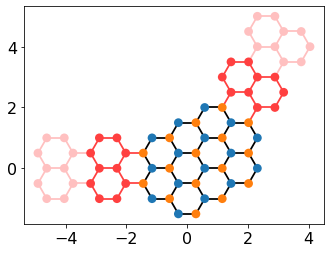

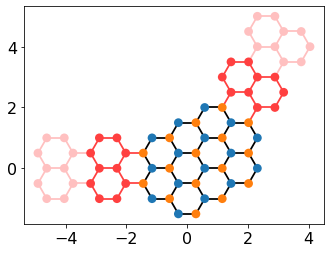

In [74]:
def hopping_lw(site1, site2): #Function defining the size of the edge lines connecting 1st, 2nd, and 3rd NN. 
    if sqrt((site1.pos[0]-site2.pos[0])**2+(site1.pos[1]-site2.pos[1])**2)>0.8:
        edge_size=0.0001
    else:
        edge_size=0.1
    return edge_size

In [115]:
#For web app also included plotting the band structure in the end so they end up in one figure, with 2 subplots next to each other
def plot_numbers():   #Plots the junctions with numbered scattering region atoms 
        sites = list(sys.sites()) #get the sites from kwant builder, the coordinates are shown in terms of lattice vectors
        fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20,10)) 
        ax.set_yticks([])
        ax.set_xticks([])
        for count,atom in enumerate(sites): #go through all the sites in scattering region
            #Check which sublattice the atom belongs as different basis vectors p1/2 are used
            if str(atom[0])[19]=='0':
                p=p1
                xshift=0
                yshift=0.05
            else:
                p=p2
                xshift=0.05
                yshift=-0.05
            if A==120: #Checks for the angle and plots a numeber for each atom
                if atom[1][0]>-D and atom[1][0]+atom[1][1]<3: #only take the atoms in scattering centre,
                    #ignoring the lead sites
                    #atom gives the number of lattice vectors v1/2 to get to the position form (0,0)
                    #plus the basis p1/2 and a small shift for better plotting
                    ax.text(atom[1][0]*v1[0]+atom[1][1]*v2[0]+p[0]+xshift,atom[1][0]*v1[1]+atom[1][1]*v2[1]+p[1]+yshift,
                            s=str(count),color='r',fontsize=13) 
            if A==60:
                if atom[1][0]>-sqrt(3)*1.5 and atom[1][1]<3:
                    ax.text(atom[1][0]*v1[0]+atom[1][1]*v2[0]+p[0]+xshift,atom[1][0]*v1[1]+atom[1][1]*v2[1]+p[1]+yshift,
                            s=str(count),color='r',fontsize=13)
            if A==180: #checks which basis the atom is in to assign different limits
                if str(atom[0])[19]=='0':
                    if atom[1][0]>=-1 and atom[1][0]<=2*D-3:
                        ax.text(atom[1][0]*v1[0]+atom[1][1]*v2[0]+p[0]+xshift,atom[1][0]*v1[1]+atom[1][1]*v2[1]+p[1]+yshift,
                                s=str(count),color='r',fontsize=13)
                if str(atom[0])[19]=='1':
                    if atom[1][0]>=0 and atom[1][0]<=2*D-2:
                        ax.text(atom[1][0]*v1[0]+atom[1][1]*v2[0]+p[0]+xshift,atom[1][0]*v1[1]+atom[1][1]*v2[1]+p[1]+yshift,
                                s=str(count),color='r',fontsize=13)
        kwant.plotter.plot(sys,site_size=0,site_color='black',lead_site_size=0.25,site_edgecolor='black',lead_color='black',ax=ax) #plots the outline of the system
        xaxis=ax.get_xlim() #get the limits of x and y for further plotting
        yaxis=ax.get_ylim()
        #check which dimension is larger and establish square plot so the hexagons are not streched/squeezed
        xdim=xaxis[1]-xaxis[0]
        ydim=yaxis[1]-yaxis[0]
        if xdim>ydim:
            change=(xdim-ydim)/2
            ax.set_ylim(yaxis[0]-change,yaxis[1]+change)
            yaxis=ax.get_ylim()
            ydim=yaxis[1]-yaxis[0]
        else:
            change=(ydim-xdim)/2
            ax.set_xlim(xaxis[0]-change,xaxis[1]+change)
            xaxis=ax.get_xlim()
            xdim=xaxis[1]-xaxis[0]
        #deleting figure frames
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        #Add the band structure plotting here as we want them in the same figure for the web app    
        momenta, energies = get_band(lead0)
        ax2.plot(momenta, energies, c='black')
        ax2.set_xticks(np.arange(-1,1.1,1))
        ax2.set_xticklabels(['-π/a', '0', 'π/a'])
        ax2.set_title('Band structure of the leads')
        ax2.set_xlabel("k-vector")
        ax2.set_ylabel("Energy (t)")
        #returns the dimensions of the structure
        return xaxis, yaxis
#A function identical to plot_numbers, but returns the dimensions of the LDOS and LCurrent plots.
#Additionally, it does not plot the bandstructure, and hides the numbered atom plot.
def plot_numbers_sys2():
        sites = list(sys2.sites()) #get the sites from kwant builder, the coordinates are shown in terms of lattice vectors
        fig, ax = plt.subplots() #only one subplot here
        kwant.plotter.plot(sys2,site_size=0,site_color='black',lead_site_size=0.25,site_edgecolor='black',lead_color='black',ax=ax) #plots the outline of the system
        xaxis2=ax.get_xlim() #get the limits of x and y for further plotting
        yaxis2=ax.get_ylim()
        #check which dimension is larger and establish square plot so the hexagons are not streched/squeezed
        xdim=xaxis2[1]-xaxis2[0]
        ydim=yaxis2[1]-yaxis2[0]
        if xdim>ydim:
            change=(xdim-ydim)/2
            ax.set_ylim(yaxis2[0]-change,yaxis2[1]+change)
            yaxis2=ax.get_ylim()
            ydim=yaxis2[1]-yaxis2[0]
        else:
            change=(ydim-xdim)/2
            ax.set_xlim(xaxis2[0]-change,xaxis2[1]+change)
            xaxis2=ax.get_xlim()
            xdim=xaxis2[1]-xaxis2[0]
        plt.close(fig) #hide the figure
        #returns the dimensions of the structure
        return xaxis2, yaxis2

In [65]:
#Used to remove specified atoms form the scattering centre by entering a list of atom numbers
def del_atoms(atoms):
    atoms=sorted(atoms, reverse=True) #sort so it starts from the largest one, such that the sites output doesn't change
    sites = list(sys.sites()) #retrieve the list of atoms and their positions in terms of the lattice vecotrs
    for atom in atoms:
        vec1=int(sites[atom][1][0]) #get the number of 1st vector
        vec2=int(sites[atom][1][1]) #numebr of 2nd vector
        lattice=str(sites[atom][0])[19] #obtain the sublattice 
        if lattice=='0':
            del sys[a(vec1,vec2)] #delete the atom
        else:
            del sys[b(vec1,vec2)]            
    return sys #return the updated system


In [66]:
#Returns the bandstructure of the lead from -pi/a to pi/a
def get_band(lead0):
    bands = kwant.physics.Bands(lead0.finalized()) #calcualtes the band structure for lead
    if H==1:
        t1=-2.7
    if H==2:
        t1=-2.77
    if H==3:
        t1=-2.7
    momenta = np.linspace(-np.pi, np.pi, 101) 
    energies = [bands(k) for k in momenta]
    for j in range(len(energies)):
        energies[j]=energies[j]/t1  
    for j in range(len(momenta)):
        momenta[j]=momenta[j]/np.pi   #momenta normalized by pi, e.g. pi=1
    return momenta, energies



In [67]:
def lead_wfn(en=0.5,mode=0):
    if H==1:
        t1=-2.7
    if H==2:
        t1=-2.77
    if H==3:
        t1=-2.7
    leads=perfect_system()
    ######Calculating the wave function in scattering center
    wf = kwant.solvers.default.wave_function(leads,energy=t1*(en+0.0001))
    for i in range(len(wf(0))):  #Loop over all wfn modes
        psi_l= wf(0)[i] #selecting the wfn incoming from left (0) and selecting the mode
        amplitude=[]
        pha=[]
        for j in range (len(psi_l)): #for each atom get amplitude and phase
            amplitude.append((np.abs(psi_l[j])))
            pha.append(phase(psi_l[j])/pi)
        first=0 
        for count,amp in enumerate(amplitude): #add normalisation for the correct color map range (No idea for a better solution)
            if amp==0.0: #select the "fake" atoms and assign a phase of -1 or 1
                if first==1:
                    pha[count]=-1
                if first==0:
                    first=1
                    pha[count]=1
        global W
        fig = plt.figure(figsize=(10.9,W/2+1)) # create the canvas for plotting #add something for length for different widths
        gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1]) 
        ax1 = plt.subplot(gs[0]) 
        ax2 = plt.subplot(gs[1],projection='polar')  
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_aspect('equal','box')
        ax1.set_title('Wavefunction, lead channel '+str(i+1)) 
        kwant.plotter.plot(leads,site_size=amplitude/max(amplitude)/2.5,site_color=pha,lead_color='black',cmap=cmocean.cm.phase,fig_size=(10,5),colorbar=False,ax=ax1)
        azimuths = np.arange(0, 361, 1)
        zeniths = np.arange(70, 100, 1)
        values = azimuths * np.ones((30, 361))    
        ax2.pcolormesh(azimuths*np.pi/180.0, zeniths, values, cmap=cmocean.cm.phase)
        ax2.set_xticklabels(['0', '', unicodedata.lookup("GREEK SMALL LETTER PI")+"/2", '', unicodedata.lookup("GREEK SMALL LETTER PI"), '', "-"+unicodedata.lookup("GREEK SMALL LETTER PI")+"/2", ''])
        ax2.set_yticks([])
        #Deleting figure frames 
        ax1.spines["top"].set_visible(False)
        ax1.spines["right"].set_visible(False)
        ax1.spines["left"].set_visible(False)
        ax1.spines["bottom"].set_visible(False)

In [68]:
#builds a perfect GNR system to compare with the system in interest
def perfect_system():
    if H==1:
        e=0
        t1=-2.7
    if H==2:
        e=-0.3
        t1=-2.77
        t2=-0.1
    if H==3:
        e=0
        t1=-2.7
        t2=-0.2
        t3=-0.18
    #setting up the system with vectors, lattice and symetries
    p1,p2=(sqrt(3)/3,0),(sqrt(3)/6,-0.5)
    v1,v2=(sqrt(3)/2, 0.5), (0, 1)
    graphene = kwant.lattice.general([v1,v2],[p1,p2],norbs=1) 
    a, b = graphene.sublattices 
    xsym = kwant.TranslationalSymmetry([-sqrt(3),0])
    leads = kwant.Builder() # Initialize system builder
    def rec(pos):
        x, y = pos
        return -sqrt(3)<=x<=4*sqrt(3) and 0<=y<=(W-1)/2
    leads[graphene.shape(rec, (0, 0))] = e    # Build scattering region
    leads[graphene.neighbors()] = t1
    if H==2:
        leads[graphene.neighbors(2)] = t2
    if H==3:
        leads[graphene.neighbors(2)] = t2
        leads[graphene.neighbors(3)] = t3 #Assign nearest-neighbour hoppings
    leads[a(0, round((W-1)/2+1, 1))] = e #add two "fake" atoms for color map normalisation
    leads[b(0, -1)] = e
    
    def lead_shape(pos):  #desing the leads, which are the same as scattering region, but without the x restirction 
        x, y = pos
        return 0 <= y <= (W-1)/2

    lead = kwant.Builder(kwant.TranslationalSymmetry([sqrt(3),0]))
    lead[graphene.shape(lead_shape, (0,0))] = e
    lead[graphene.neighbors()] = t1
    if H==2:
        lead[graphene.neighbors(2)] = t2
    if H==3:
        lead[graphene.neighbors(2)] = t2
        lead[graphene.neighbors(3)] = t3
    
    leads.attach_lead(lead.reversed()) #attach the leads
    leads.attach_lead(lead)
    
    leads = leads.finalized() #finalize the system
    return leads

In [69]:
#Plotting function to get both Conductance and DOS
def cond_and_dos(Emin,Emax):
    if H==1:
        t1=-2.7
    if H==2:
        t1=-2.77
    if H==3:
        t1=-2.7
    trans=[] #empty list to store values
    perf_trans=np.load('perfect/con_'+str(W)+'_3k.npz') #loads previously calculated perfect lead transmission data
    dos=[]
    perf_dos=np.load('perfect/dos_'+str(W)+'_3k.npz') #loads previously calculated perfect lead dos data
    energies=np.linspace((Emin-0.00001)*t1, (Emax+0.00001)*t1, num=300) #specify energy grid
    cutmin=int((Emin+3)*500+1) #defines places where we need to cut our perfect trans and dos arrays.
    cutmax=int((Emax+3)*500-1)
    for i,energy in enumerate(energies):
        if i%10==0:
            progress.value=i/5 
        dos.append(np.sum(kwant.ldos(fsys,energy))) #sum over all atom ldos
        smatrix = kwant.smatrix(fsys, energy,check_hermiticity=False) #calculates the S matrix of the system in interest
        trans.append(smatrix.transmission(1,0)) #calcualtes the transmission coefficient
    for j in range(len(energies)):
        energies[j]=energies[j]/t1 #convert energies back in terms of t
    progress.value=61
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20,10)) 
    ax.plot(energies, trans, label="Junction")
    ax.plot(perf_trans['arr_0'][cutmin:cutmax], perf_trans['arr_1'][cutmin:cutmax], label="Lead")
    ax.legend()
    ax.set_xlabel("Energy (t)")
    ax.set_ylabel("Conductance (e\N{SUPERSCRIPT TWO}/h)")
    ax.set_ylim(ymin=0)
    ax.set_xticks(np.arange(Emin, Emax+(Emax-Emin)/10, round((Emax-Emin)/10,2)))
    ax.xaxis.set_tick_params(rotation=90)
    ax2.plot(energies, dos,label='Junction')
    ax2.plot(perf_dos['arr_0'][cutmin:cutmax], perf_dos['arr_1'][cutmin:cutmax],label='Lead')
    ax2.legend()
    ax2.set_xlabel("Energy (t)")
    ax2.set_ylabel("DOS")
    ax2.set_ylim(ymin=0)
    ax2.set_xticks(np.arange(Emin, Emax+(Emax-Emin)/10, round((Emax-Emin)/10,2)))
    ax2.xaxis.set_tick_params(rotation=90)
    #rounding values
    for i in range(len(energies)):
        energies[i]=round(energies[i],4)
        trans[i]=round(trans[i],4)
        dos[i]=round(dos[i],4)
    return energies, trans, dos

In [125]:
#Plotting function to get both ldos and current
def ldos_and_current(Energy):
    if H==1:
        t1=-2.7
    if H==2:
        t1=-2.77
    if H==3:
        t1=-2.7
    ldos=kwant.ldos(fsys,t1*(Energy+0.0001)) 
    max_ldos=max(ldos)    
    if max_ldos==0:
        print ("Please select another energy value as there are no bands at this energy")
    if max_ldos>0:
        ldos=ldos/max(ldos)
        plt.figure(figsize=(21,9), frameon=False)
        gs = gridspec.GridSpec(1, 3, width_ratios=[31, 31, 1]) 
        ax = plt.subplot(gs[0]) 
        ax2 = plt.subplot(gs[1])
        ax3 = plt.subplot(gs[2]) 
        ax.set_ylim(yaxis2)
        ax.set_xlim(xaxis2)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Local density of states')
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        kwant.plot(fsys_plot,site_size=ldos/1.75,site_color='blue', lead_color='black',ax=ax)
        circle1 = plt.Circle((xaxis2[0]+1,yaxis2[1]-2), 0.325, color='blue')
        ax.add_artist(circle1)
        ax.text(xaxis2[0]+1.5,yaxis2[1]-2,s=str("{:.2E}".format(max_ldos)))
        #Current part
        psi = kwant.wave_function(fsys,energy=t1*(Energy+0.0001))(0) #get the wavefunction
        hop_lead_nr=kwant.plotter.sys_leads_hoppings(fsys,num_lead_cells=0)
        hoppings=kwant.plotter.sys_leads_hopping_pos(fsys, hop_lead_nr[0]) #get the hoppings in the system for plotting the current lines
        N=len(hoppings[0])
        ovcurrent=[0]*2*N #make a list of 0's
        channels=len(psi) #number of bands at that energy
        for wfn in psi:
            J=kwant.operator.Current(fsys) 
            current=J(wfn) #get the local current value
            ovcurrent=list(map(operator.add, current,ovcurrent)) #add all the current values together from different bands at the same energy
        values=list(ovcurrent)[:N] #only take one direction of current (have teh same value (signe diff) both directions n->m and m->n)
        dim=abs(xaxis2[1]-xaxis2[0]) #dimension to normalize arrow size in the plot
        normvalues=values/max(values)
        for j in range(N):
            if normvalues[j]<0:
                ax2.annotate("", xy=(hoppings[1][j][0], hoppings[1][j][1]), 
                            xytext=(hoppings[0][j][0],hoppings[0][j][1]), 
                            arrowprops=dict(color=cm.inferno(int(round(abs(values[j]*256/channels)))),headlength=100/dim,headwidth=150/dim*abs(normvalues[j]),width=70/dim*abs(normvalues[j])))
            if normvalues[j]>=0:
                ax2.annotate("", xy=(hoppings[0][j][0], hoppings[0][j][1]),
                             xytext=(hoppings[1][j][0],hoppings[1][j][1]),
                             arrowprops=dict(color=cm.inferno(int(round(abs(values[j]*256/channels)))),headlength=100/dim,headwidth=150/dim*abs(normvalues[j]),width=70/dim*abs(normvalues[j])))
        kwant.plotter.plot(fsys_plot,site_size=0,site_color='white',hop_color='white',lead_color='black',lead_site_size=0.25,ax=ax2)
        ax2.set_yticks([])
        ax2.set_xticks([])
        ax2.set_ylim(yaxis2)
        ax2.set_xlim(xaxis2)
        ax2.set_title('Local current map')
        #Gets rid of frames
        ax2.spines["top"].set_visible(False)
        ax2.spines["right"].set_visible(False)
        ax2.spines["left"].set_visible(False)
        ax2.spines["bottom"].set_visible(False)
        
        smatrix = kwant.smatrix(fsys, (Energy+0.00001)*t1) #calculates the S matrix of the system in interest
        T=(smatrix.transmission(1,0)) #calcualtes the transmission coefficient
        ax2.text(xaxis2[0]+1.5,yaxis2[1]-2,s=str("Transmission:"+"{:.2E}".format(T)))
        

        # Set the colormap and norm to correspond to the data for which
        # the colorbar will be used.
        cmap = mpl.cm.inferno
        norm = mpl.colors.Normalize(vmin=0, vmax=channels)

        # ColorbarBase derives from ScalarMappable and puts a colorbar
        # in a specified axes, so it has everything needed for a
        # standalone colorbar.  There are many more kwargs, but the
        # following gives a basic continuous colorbar with ticks
        # and labels.
        cb1 = mpl.colorbar.ColorbarBase(ax=ax3, cmap=cmap,
                                        norm=norm,
                                        orientation='vertical')
        cb1.set_label('Local probability current')
    

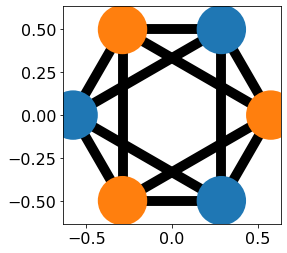

In [219]:
t1=2.75
t2=0.2
t3=0.1
v1,v2=(sqrt(3)/2, 0.5), (0, 1)
p1,p2=(sqrt(3)/3,0),(sqrt(3)/6,-0.5)
graphene = kwant.lattice.general([v1,v2],[p1,p2],norbs=1) 
a, b = graphene.sublattices 
ysym = kwant.TranslationalSymmetry([-sqrt(3),0])
sys = kwant.Builder()
def circle(pos): #define the scattering region dimensions depending on angle
    x, y = pos
    return -1<=x<2*sqrt(3)/3 and -0.5<=y<=0.50
sys[graphene.shape(circle, (0, 0))] = 0
sys[graphene.neighbors()] = t1 
sys[graphene.neighbors(2)] = t2
#if H==3:
    #sys2[graphene.neighbors(2)] = t2
    #sys2[graphene.neighbors(3)] = t3
kwant.plotter.plot(sys)
sys.finalized()

In [220]:
hop_lead_nr=kwant.plotter.sys_leads_hoppings(sys,num_lead_cells=0)

In [221]:
hoppings=kwant.plotter.sys_leads_hopping_pos(sys, hop_lead_nr[0])

In [230]:
for i in range(len(hoppings[1])):
    a=sqrt((hoppings[1][i][0]-hoppings[0][i][0])**2+(hoppings[1][i][1]-hoppings[0][i][1])**2)
    print(a)

0.5773502691896257
0.5773502691896257
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.5773502691896257
0.5773502691896257
0.5773502691896257
0.5773502691896257
1.0
0.9999999999999999
1.0


In [227]:
hoppings[1][0][0]

0.28867513459481287

In [116]:
oldreset=0
ireset=0 #dummy variables to workaround that one couldnt change the system parameters while remove atoms was submitted forcing to reset system first
ldos_current=0  #dummy variable to workaround for loading sequence of cells, some info loaded in the next cell caused a crash
style = {'description_width': 'initial'} #To display the whole discripriotn of the button, otherwise the string is cut

#Widget to build the structure
def make_and_display(Angle,Width,Distance,Shift,QD,Chirality,Hopping,RemAtoms):
    if Width%2!=0:                               #some restrictions on what parameters you can change with the selected angle/width
        Selection.children[5].disabled=True
    if Width%2==0:
        Selection.children[5].disabled=False
    if Angle==60:
        Selection.children[2].disabled=True
        Selection.children[2].value=1
    if Angle==120:
        Selection.children[2].max=3
    if Angle!=60:
        Selection.children[2].disabled=False
    if Angle!=180:
        Selection.children[3].disabled=True
        Selection.children[4].disabled=True
        Selection.children[3].value=0
        Selection.children[4].value=0
    if Angle==180:
        Selection.children[2].max=5
        Selection.children[3].disabled=False
        Selection.children[4].disabled=False
        if Selection.children[3].value!=0:
            Selection.children[4].disabled=True 
        if Selection.children[4].value!=0:
            Selection.children[3].disabled=True
    #restrictions end    
    global sys, sys2, sys3, lead0, lead1, a, b, v1, v2, p1, p2, A, D, W, S, F, Q, H, oldreset
    #This part checks if there are atoms to remove and hence the system has been already built or if len(RemAtoms)=0
    #then new system will be built. Essentially this is "cheating" by always passing a list of atoms to remove, but
    #when we build a new system the list is empty.
    if len(RemAtoms)>0:         #Checks if there is a string of atoms entered in the remove atoms cell
        if ireset==oldreset:   #Dummy variable to check if the string was submitted now or is it still active from previous submission
            RemAtoms=[]     #Deletes the old string and proceeds to build a new system 
        if ireset!=oldreset:   #If the string to remove atoms is newly submitted, then removes atoms 
            atoms = map(int, RemAtoms.split(',')) #get a list from a string
            atoms=set(atoms) #gets rid of dublicates
            sys=del_atoms(atoms) #return new instance of sys with atoms removed, all other paramaters stay (lead,v1,A,D,W,etc.)
            oldreset+=1
    if len(RemAtoms)==0:     #If there is no list of atoms to remove then it means we build a new system with new params
        sys, sys2, sys3, lead0, lead1, a, b, v1, v2, p1, p2, A, D, W, S, F, Q, H = make_system(A=Angle,W=Width,D=Distance,S=Shift,F=Chirality, Q=QD, H=Hopping)
    #returns dimensions of the system for the system+band structure plots
    global xaxis, yaxis 
    xaxis, yaxis = plot_numbers()
    #returns dimensions of the system for LDOS and current plots
    global xaxis2, yaxis2
    xaxis2, yaxis2 = plot_numbers_sys2()
    if ldos_current==1:
        Single_en_at.children[0].value+=0.1 
        Single_en_at.children[0].value-=0.1 
    #Workaround to update ldos and current plots, ldos_current is dummy variable active when the function is called later

#The main widget with selections for the system. Every time a value is changed, the system will be rebuilt. The problem
#is with removing atoms or reseting system. Two aditional functions (reset and remove) and buttons are used to 
#change the hidden RemAtoms selection. Therefore RemAtoms here is needed so that we can "rebuild" our system either by
#reseting or removing some atoms as the widget executes the function anytime a parameter is changed. 
#In the initial widget hence this RemAtoms section must be hidden and is set to be empty.
Selection = interactive(make_and_display, Angle=widgets.ToggleButtons(description_tooltip="Select the angle between the two leads",options=[('180°',180),('120°',120),('60°',60)], value=120),
                        Width=widgets.IntSlider(description_tooltip="Select the width of the leads in terms of carbon atoms",min=3, max=11, step=1, value=5, description='Lead Width'),
                        Distance=widgets.IntSlider(description_tooltip="Change the horizontal distance between the leads, not available with 60° angle",min=1,step=1, value=1),
                        Shift=widgets.IntSlider(description_tooltip="Shift one lead upwards with respect to another, only available with 180° angle",min=0,max=5,step=1, value=0),
                        QD=widgets.IntSlider(description_tooltip="Selects the size of the quantum dot width", min=0, max=5, step=1, value=0, description='QD Width'),
                        Chirality=widgets.ToggleButtons(description_tooltip="For even-numbered widths, select chirality of the lead",options=[('up',0),('down',1)]),
                        Hopping=widgets.Dropdown(options=[('First',1), ('Second',2), ('Third',3)],disabled=False),
                        RemAtoms=widgets.Text(value='',description='Previously removed atoms',style=style))

#widgets.IntSlider(description_tooltip="Changes size of quantum dot", min=0, max=5, step=1, value=0, description='Junction Width',style=style)
#[widgets.Label(value='Junction Width'), widgets.IntSlider(description_tooltip="Changes size of quantum dot", min=0, max=5, step=1, value=0)]

Selection.children[7].layout.visibility="hidden" #Hide RemAtoms seciton

#A button that starts the function reset_values that changes the RemAtoms value in the widget and hence the system is rebuilt
def reset_values(b):
    """Reset the interactive plots to inital values."""
    Selection.children[7].value = ''

reset_button = widgets.Button(description = "Reset system",tooltip='Back to original system with no atoms removed')
reset_button.on_click(reset_values)


In [117]:
display(Selection) #displays the initial widget

###Remove atoms part####
#Manual interact, where the function is executed only after clicking the button. Otherwise while you are typing the 
#function would be executed and probably fail when you type a comma between atoms. Problem here was the naming of the 
#manual interact button to "Remove atoms". Solved by copying a piece of code , however it displays the widget without
#the display(widget) function. Just makes the code messier, but works...
remov_atoms=interact.options(manual=True, manual_name="Remove atoms") 
rem_wid=widgets.Text(description_tooltip="Enter the numbers of the atoms you want to remove separated by a comma (,)",description='Enter atoms to be removed:',placeholder='e.g. 1,4,3',style=style)
@remov_atoms(Remove=rem_wid)
def removing_atoms(Remove):    
    global ireset  #ireset is used to control when a new value for remove atoms is entered
    if Remove == Selection.children[7].value:  #If the submission is the same string of atoms, the function doesn't update
        if len(Remove)>1:
            ireset+=1
            Remove=str(Remove[len(Remove)-1:])+","+str(Remove[:len(Remove)-2])
            Selection.children[7].value = Remove
        if len(Remove)==1: #If only one atom is entered and is the same as previous, Don't have a solution yet....
            print ("Sorry for my weak programming skills: Please reset the system and remove the last two atoms together in one submission")
    else:
        ireset+=1
        Selection.children[7].value = Remove
    rem_wid.value=''  #clear the field after entering which atoms to delete

    
#Displays the reset_button        
display(reset_button)

interactive(children=(ToggleButtons(description='Angle', description_tooltip='Select the angle between the two…

interactive(children=(Text(value='', description='Enter atoms to be removed:', description_tooltip='Enter the …

Button(description='Reset system', style=ButtonStyle(), tooltip='Back to original system with no atoms removed…

Select the energy range ('*Min Energy*' and '*Max Energy*') and press '*Calculate*' for computing the conductance and the density of states of the designed GNR junction. The results are compared to that of the ideal leads. Since this computation may take some time, its progress is indicated by the progress bar. You may copy the datasets to the clipboard. 

In [118]:
#Again a manual interact widget just like the Remove atoms. Finalizes the system and then plots conductance and dos. 
#Progress adds a progress bar, when the calculate_cond function is called and hides it after the calculation is done
progress=widgets.IntProgress(value=0,min=0,max=62,step=1,description='Progress:',bar_style='info',orientation='horizontal')
progress.layout.visibility='hidden'
interact_calc=interact.options(manual=True, manual_name="Calculate")
@interact_calc(Emin=widgets.FloatSlider(description_tooltip="Select the lowest energy of the desired range",min=-3, max=3, step=0.1, value=-3, description="Min Energy (t)",style=style),Emax=widgets.FloatSlider(min=-3, max=3, step=0.1, value=3,description_tooltip="Select the highest energy of the desired range",description="Max Energy (t)",style=style))
def calculate_cond(Emin,Emax):
    global fsys, energies, trans, dos
    progress.layout.visibility="initial" 
    fsys=sys2.finalized()
    energies, trans, dos = cond_and_dos(Emin,Emax)
    progress.layout.visibility="hidden"
display(progress)
#copy to clipboard functionality. Creates a button which copies the datasets. The data is organized into columns.
#first column is energy, second is transmission, third is dos. Numbers are all rounded to 4 decimal places.
empty_string=""
copy_button = widgets.Button(description = "Copy data",tooltip='First column is energy data, second is transmission data, third is dos data')
def copy_clip(b):
    dataset=np.array([list([format(ints,'.4f') for ints in energies]), list([format(ints,'.4f') for ints in trans]), list([format(ints,'.4f') for ints in dos])]).T.tolist()
    dataset_c=[]
    for i in range(len(dataset)):
        dataset_c.extend(dataset[i])
    empty_string=""
    for i in range(int(len(dataset_c)/3)):
        if i==0:
            empty_string="\t".join(dataset_c[0:3])
        if i!=0:
            empty_string=empty_string+"\n"+"\t".join(dataset_c[int(3*i):int(3*i+3)])
    pyperclip.copy(empty_string)
copy_button.on_click(copy_clip)
display(copy_button)

interactive(children=(FloatSlider(value=-3.0, description='Min Energy (t)', description_tooltip='Select the lo…

IntProgress(value=0, bar_style='info', description='Progress:', layout=Layout(visibility='hidden'), max=62)

Button(description='Copy data', style=ButtonStyle(), tooltip='First column is energy data, second is transmiss…

In [126]:
#Widget for displaying current, ldos and wavefunction. Two selections - energy (for all) and mode(just for wfn)
def single(Energy):
    global fsys, fsys_plot
    fsys=sys2.finalized()
    fsys_plot=sys3.finalized()
    ldos_and_current(Energy)
    lead_wfn(en=Energy)    
    
Single_en_at = interactive(single,Energy=widgets.FloatText(description_tooltip="Enter the energy at wich you want to calculate the properties",value=0.5,description="Energy (t)"))
ldos_current=1  #dummy variable vor loading cells
    

Select an energy at which the local density of states, local current map and the wavefunction(s) of the lead channel(s) are displayed. The local current map displays the cumulative current from all channels involved at the selected energy.

In [127]:
display(Single_en_at)

interactive(children=(FloatText(value=0.5, description='Energy (t)', description_tooltip='Enter the energy at …